# Flujo de preparación de datos con stitcher 560 px

Este notebook resume el proceso que seguimos para preparar las imágenes antes del entrenamiento: tomamos una imagen completa, la dividimos en parches de 560×560 px mediante el stitcher y vemos cómo aplicamos las aumentaciones sobre los parches que contienen animales.


## Pasos

1. Cargar una imagen de ejemplo junto con sus anotaciones COCO.
2. Visualizar la imagen completa y sobreponer las cajas de los animales.
3. Aplicar el stitcher con ventana de 560 px y revisar los parches generados.
4. Identificar los parches con animales y mostrar sus cajas.
5. Aplicar la pipeline de aumentaciones sobre esos parches y comparar los resultados.


In [10]:
import json
import math
import random
import sys
from pathlib import Path
from typing import Dict, List, Tuple

import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
from PIL import Image

plt.rcParams["figure.facecolor"] = "white"


def find_repo_root(start: Path) -> Path:
    for path in [start, *start.parents]:
        if (path / "data-sample").exists() and (path / "notebooks").exists():
            return path
    raise RuntimeError("No se encontró el repositorio desde " + str(start))

REPO_ROOT = find_repo_root(Path.cwd().resolve())
if str(REPO_ROOT / "notebooks") not in sys.path:
    sys.path.insert(0, str(REPO_ROOT / "notebooks"))

from utils.rf_detr import SimpleStitcher

PATCH_SIZE = 560
OVERLAP = 0
MIN_VISIBILITY = 0.1
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
IMAGE_NAME = "L_07_05_16_DSC00702.JPG"

images_dir = REPO_ROOT / "data-sample" / "train_full"
annotations_path = REPO_ROOT / "data-sample" / "groundtruth" / "json" / "train_annotations.coco.json"

if not images_dir.exists():
    raise FileNotFoundError(images_dir)
if not annotations_path.exists():
    raise FileNotFoundError(annotations_path)

random.seed(7)
np.random.seed(7)
torch.manual_seed(7)

In [11]:
with annotations_path.open("r", encoding="utf-8") as fh:
    coco = json.load(fh)

images_by_name: Dict[str, Dict] = {img["file_name"]: img for img in coco["images"]}
if IMAGE_NAME not in images_by_name:
    raise ValueError(f"La imagen {IMAGE_NAME} no está en las anotaciones")

image_info = images_by_name[IMAGE_NAME]
annotations_by_image: Dict[int, List[Dict]] = {}
for ann in coco["annotations"]:
    annotations_by_image.setdefault(ann["image_id"], []).append(ann)

image_annotations = annotations_by_image.get(image_info["id"], [])
image_path = images_dir / IMAGE_NAME

print(f"Imagen seleccionada: {IMAGE_NAME}")
print(f"Resolución: {image_info['width']} x {image_info['height']}")
print(f"Anotaciones encontradas: {len(image_annotations)}")


Imagen seleccionada: L_07_05_16_DSC00702.JPG
Resolución: 6000 x 4000
Anotaciones encontradas: 55


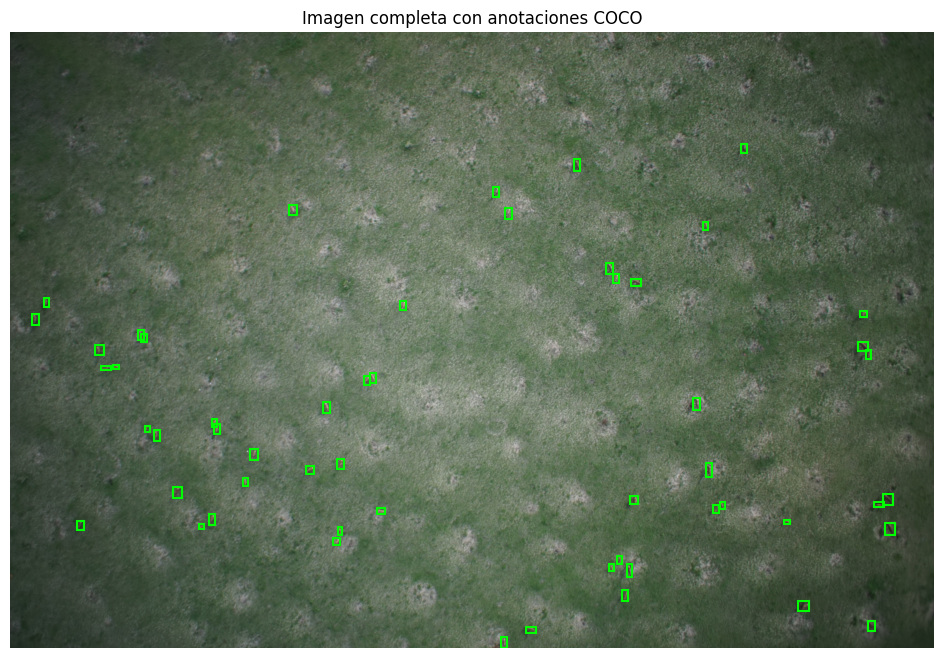

In [12]:
image = Image.open(image_path).convert("RGB")
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
for ann in image_annotations:
    x, y, w, h = ann["bbox"]
    rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor="lime", facecolor="none")
    ax.add_patch(rect)
ax.set_title("Imagen completa con anotaciones COCO")
ax.axis("off")
plt.show()


In [13]:
class DummyModel(torch.nn.Module):
    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        batch_size = x.shape[0]
        device = x.device
        logits = torch.zeros((batch_size, 1, 1), device=device)
        boxes = torch.zeros((batch_size, 1, 4), device=device)
        return {"pred_logits": logits, "pred_boxes": boxes}

stitcher = SimpleStitcher(
    model=DummyModel(),
    patch_size=PATCH_SIZE,
    overlap=OVERLAP,
    batch_size=8,
    confidence_threshold=0.0,
    device="cpu",
    label_offset=0,
)

image_tensor = stitcher._load_tensor(image_path)
patches_tensor, positions = stitcher._make_patches(image_tensor)
print(f"Total de parches generados: {len(positions)}")


Total de parches generados: 88


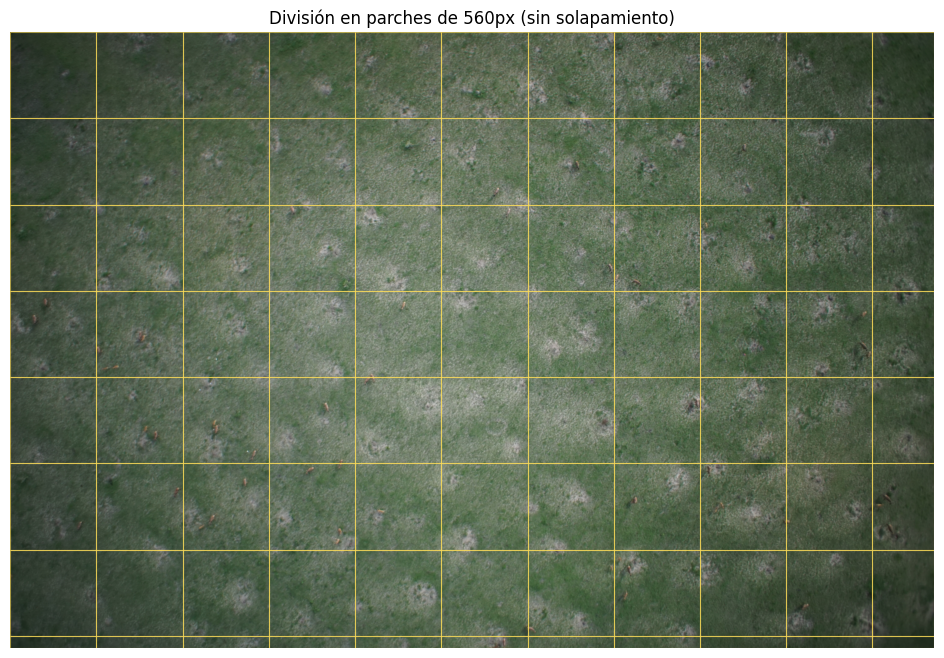

In [14]:
img_width, img_height = image.size
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(image)
for (y_off, x_off) in positions:
    rect = patches.Rectangle(
        (x_off, y_off),
        min(PATCH_SIZE, img_width - x_off),
        min(PATCH_SIZE, img_height - y_off),
        linewidth=0.8,
        edgecolor="#ffde59",
        facecolor="none",
        alpha=0.6,
    )
    ax.add_patch(rect)
ax.set_title(f"División en parches de {PATCH_SIZE}px (sin solapamiento)")
ax.axis("off")
plt.show()


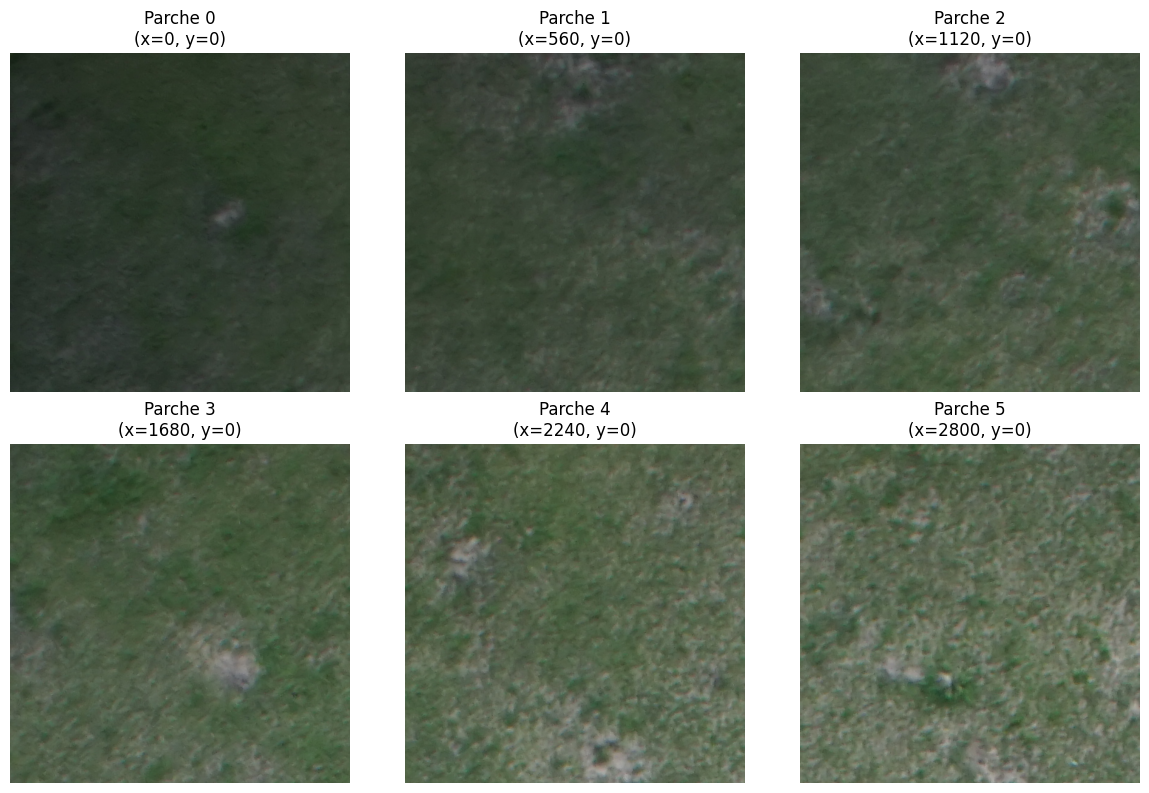

In [15]:
def tensor_to_uint8(tensor: torch.Tensor) -> np.ndarray:
    array = tensor.detach().cpu().numpy().transpose(1, 2, 0)
    return np.clip(array * 255.0, 0, 255).astype(np.uint8)

num_examples = 6
cols = 3
rows = math.ceil(num_examples / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for idx, ax in enumerate(axes.flat):
    if idx < num_examples and idx < patches_tensor.shape[0]:
        patch_img = tensor_to_uint8(patches_tensor[idx])
        y_off, x_off = positions[idx]
        ax.imshow(patch_img)
        ax.set_title(f"Parche {idx}\n(x={x_off}, y={y_off})")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [16]:
def coco_to_xyxy(bbox: List[float]) -> np.ndarray:
    x, y, w, h = bbox
    return np.array([x, y, x + w, y + h], dtype=np.float32)

def bbox_intersection(box_a: np.ndarray, box_b: np.ndarray) -> np.ndarray | None:
    x1 = max(box_a[0], box_b[0])
    y1 = max(box_a[1], box_b[1])
    x2 = min(box_a[2], box_b[2])
    y2 = min(box_a[3], box_b[3])
    if x2 <= x1 or y2 <= y1:
        return None
    return np.array([x1, y1, x2, y2], dtype=np.float32)

def clip_to_patch(box: np.ndarray, offset: Tuple[int, int]) -> np.ndarray:
    x_off, y_off = offset
    return box - np.array([x_off, y_off, x_off, y_off], dtype=np.float32)

animal_patches: List[Dict] = []
for idx, (y_off, x_off) in enumerate(positions):
    patch_bounds = np.array([
        x_off,
        y_off,
        min(x_off + PATCH_SIZE, img_width),
        min(y_off + PATCH_SIZE, img_height),
    ], dtype=np.float32)
    patch_annotations: List[Dict] = []
    for ann in image_annotations:
        ann_box = coco_to_xyxy(ann["bbox"])
        intersection = bbox_intersection(ann_box, patch_bounds)
        if intersection is None:
            continue
        ann_area = (ann_box[2] - ann_box[0]) * (ann_box[3] - ann_box[1])
        inter_area = (intersection[2] - intersection[0]) * (intersection[3] - intersection[1])
        visibility = inter_area / ann_area if ann_area > 0 else 0.0
        if visibility < MIN_VISIBILITY:
            continue
        patch_annotations.append({
            "bbox_xyxy": clip_to_patch(intersection, (x_off, y_off)),
            "category_id": ann["category_id"],
        })
    if patch_annotations:
        animal_patches.append({
            "index": idx,
            "offset": (x_off, y_off),
            "tensor": patches_tensor[idx],
            "annotations": patch_annotations,
        })

print(f"Parches con animales: {len(animal_patches)}")


Parches con animales: 32


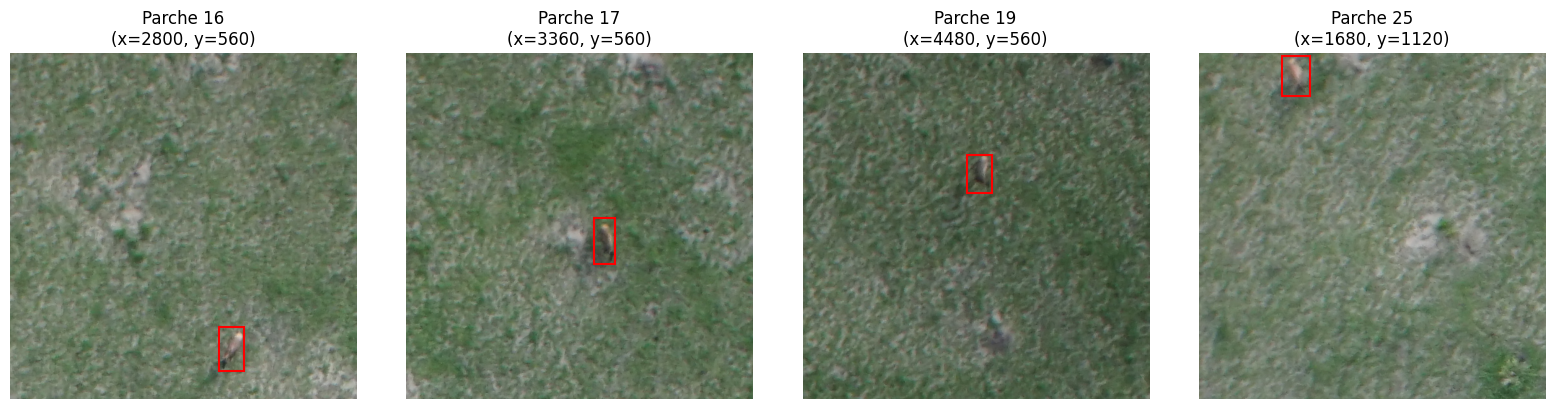

In [17]:
examples = min(4, len(animal_patches))
fig, axes = plt.subplots(1, examples, figsize=(4 * examples, 4))
if examples == 1:
    axes = [axes]
for i in range(examples):
    data = animal_patches[i]
    patch_img = tensor_to_uint8(data["tensor"])
    axes[i].imshow(patch_img)
    for ann in data["annotations"]:
        x1, y1, x2, y2 = ann["bbox_xyxy"]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor="red", facecolor="none")
        axes[i].add_patch(rect)
    axes[i].set_title(f"Parche {data['index']}\n(x={data['offset'][0]}, y={data['offset'][1]})")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


### Aumentaciones HerdNet

Usamos la misma pipeline que en `experiments/HerdNet/experiment_1/scripts/train_stage1.py`: flips vertical/horizontal, rotaciones de 90°, ajustes suaves de brillo/contraste y desenfoque ligero, seguidos por la normalización con los valores de ImageNet.


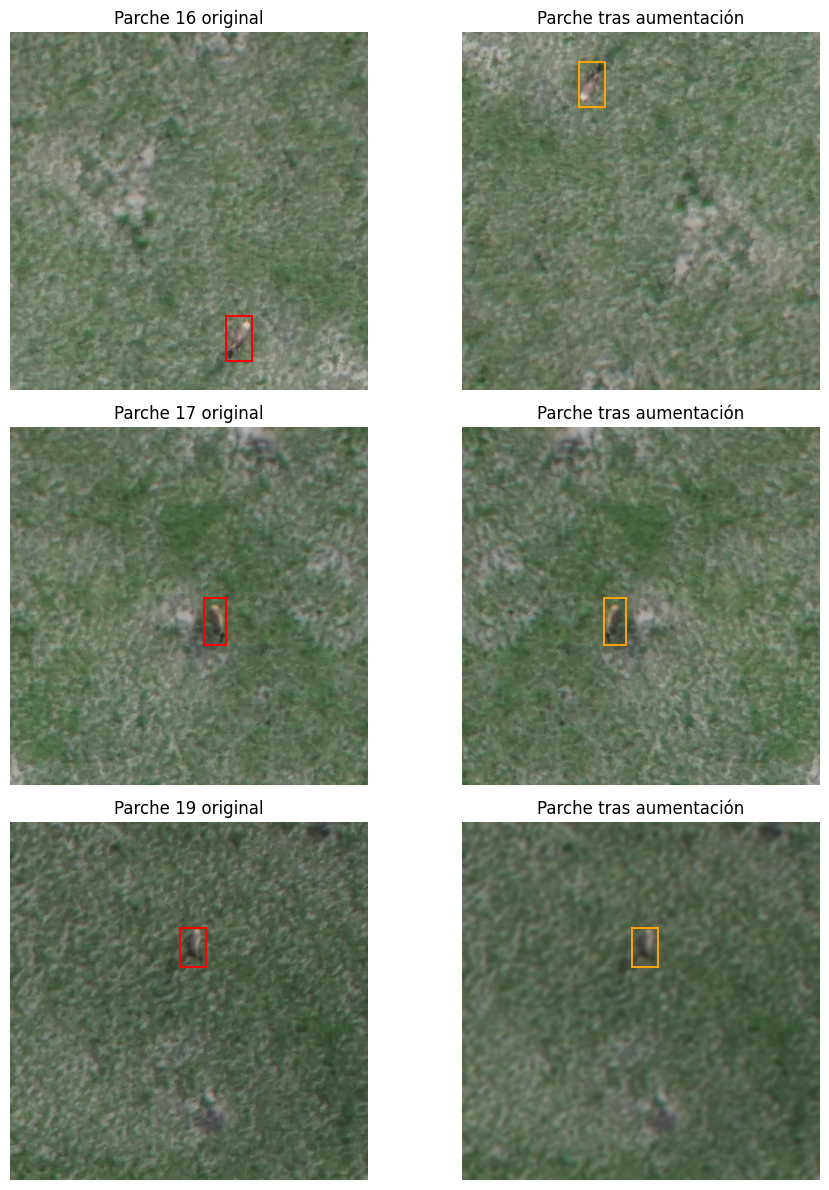

In [18]:
augment = A.Compose(
    [
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
        A.Blur(blur_limit=15, p=0.2),
        A.Normalize(mean=MEAN, std=STD, p=1.0),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["labels"],
        min_visibility=MIN_VISIBILITY,
    ),
)

mean_arr = np.array(MEAN, dtype=np.float32)
std_arr = np.array(STD, dtype=np.float32)

num_aug_examples = min(3, len(animal_patches))
fig, axes = plt.subplots(num_aug_examples, 2, figsize=(10, num_aug_examples * 4))
if num_aug_examples == 1:
    axes = np.array([axes])

for row in range(num_aug_examples):
    data = animal_patches[row]
    original = tensor_to_uint8(data["tensor"])
    bboxes = [ann["bbox_xyxy"].tolist() for ann in data["annotations"]]
    labels = [ann["category_id"] for ann in data["annotations"]]

    ax_orig = axes[row, 0]
    ax_orig.imshow(original)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.4, edgecolor="red", facecolor="none")
        ax_orig.add_patch(rect)
    ax_orig.set_title(f"Parche {data['index']} original")
    ax_orig.axis("off")

    augmented = augment(image=original, bboxes=bboxes, labels=labels)
    aug_img = augmented["image"]
    aug_bboxes = augmented["bboxes"]

    aug_img_vis = np.clip((aug_img * std_arr) + mean_arr, 0.0, 1.0)
    aug_img_vis = (aug_img_vis * 255).astype(np.uint8)

    ax_aug = axes[row, 1]
    ax_aug.imshow(aug_img_vis)
    for bbox in aug_bboxes:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.4, edgecolor="orange", facecolor="none")
        ax_aug.add_patch(rect)
    ax_aug.set_title("Parche tras aumentación")
    ax_aug.axis("off")

plt.tight_layout()
plt.show()


## Conclusiones

- El stitcher divide la imagen en parches manejables sin perder contexto gracias al padding automático en los bordes.
- Solo retenemos los parches con suficiente visibilidad de animales para entrenar el detector.
- Las aumentaciones de Albumentations mantienen consistentes las cajas de detección y amplían la variabilidad de los datos.
